In [ ]:
! pip install --upgrade --quiet --no-deps scikit-learn statsmodels yfinance
! clear

     |████████████████████████████████| 9.8 MB 9.5 MB/s 


## Задача прогнозування індексу NIKKEI за допомогою цінових показників акцій індексу S&P 500

In [ ]:
from datetime import datetime

import pandas as pd
import numpy as np
import yfinance
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, ElasticNetCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import (mean_absolute_error,
                             mean_squared_error,
                             mean_absolute_percentage_error)
import statsmodels.api as sm


from matplotlib import pyplot as plt
import seaborn as sns
sns.set()

### У якості регрессорів обрано акції NVIDIA, Cisco, Visa та Apple. Період формування вибірки: 01.01.2019 - 31.12.2020

In [ ]:
american_companies = ['NVDA', 'CSCO', 'V', 'AAPL']
japanese_index = ['^N225']
jpy_usd = ['JPY=X']


def read_tickers(tickers):
  """
  Read and process stock prices fro given list of tickers
  """
  df = pd.DataFrame(columns=['Date'])
  df['Date'] = pd.date_range('2019-01-01', '2020-12-31', freq='D')
  df.set_index('Date', inplace=True)
  for ticker in tickers:
    ticker = yfinance.Ticker(ticker)
    history_prices = np.log(ticker
               .history('1d', start='2019-01-01', end='2020-12-31')
               ['Close']
               )

    df[ticker.ticker] = history_prices
  return df

def plot_tickers(tickers_dataset):
  """
  Plot tickers from tickers dataset
  """
  number_of_plots = len(tickers_dataset.columns)
  fig, ax = plt.subplots(number_of_plots, figsize=(10, 15))
  fig.suptitle('Stock Prices')
  range_of_days = list(range(len(tickers_dataset)))
  for index, ticker in enumerate(tickers_dataset.columns):
    ax[index].plot(range_of_days, tickers_dataset[ticker].values.ravel())
    ax[index].set(ylabel=ticker)
  plt.show()

def plot_correlation(tickers_dataset):
  """
  Plot Correlation
  """
  fig = plt.figure(figsize=(10,10))
  sns.heatmap(df.corr(), cmap="YlGnBu", annot=True)
  fig.show()

def shift_data(tickers_dataset, y_col, days_shift, include_lag=None):
  """
  Add to data some lags for given column
  """
  new_dataset = tickers_dataset.copy()
  for lag in range(1, days_shift + 1):
    new_dataset[f'{y_col}_-{lag}'] = new_dataset[y_col].shift(lag)

  return new_dataset

def dickey_fuller_pval(tickers_dataset, column, trend):
  """
  Calculate p-value for Augmented Dickey-Fuller Test
  """
  return sm.tsa.stattools.adfuller(tickers_dataset[column], regression=trend)[1]

def get_scores_for_model(ml_model, X_train, y_train, X_test, y_test):
  """
  Score model (R^2, MAE, MSE, RMSE)
  """

  report_df = {
      "Sample Type":[],
      "Coef. of determination":[],
      "Mean Squared Error": [],
      "Mean Absolute Error": [],
      "Mean Absolute Percentage Error": []}

  train_r2 = ml_model.score(X_train, y_train)
  test_r2 = ml_model.score(X_test, y_test)
  y_train_pred = ml_model.predict(X_train)
  y_test_pred = ml_model.predict(X_test)

  train_mae = mean_absolute_error(y_train_pred, y_train)
  test_mae = mean_absolute_error(y_test_pred, y_test)

  train_mse = mean_squared_error(y_train_pred, y_train)
  test_mse = mean_squared_error(y_test_pred, y_test)

  train_mape = mean_absolute_percentage_error(y_train_pred, y_train)
  test_mape = mean_absolute_percentage_error(y_test_pred, y_test)
  report_df["Sample Type"].extend(["Train", "Test"])
  report_df["Coef. of determination"].extend([train_r2, test_r2])
  report_df["Mean Squared Error"].extend([train_mse, test_mse])
  report_df["Mean Absolute Error"].extend([train_mae, test_mae])
  report_df["Mean Absolute Percentage Error"].extend([train_mape, test_mape])

  return pd.DataFrame(report_df).set_index("Sample Type")

In [ ]:
df = read_tickers(american_companies + japanese_index)
jpy_usd_dataset = read_tickers(jpy_usd)
df[japanese_index] -= jpy_usd_dataset.values
df.head(5)

,NVDA,CSCO,V,AAPL,^N225
Date,,,,,
2019-01-01,NaN,NaN,NaN,NaN,NaN
2019-01-02,3.520878,3.647825,4.865788,3.642007,NaN
2019-01-03,3.458559,3.610779,4.829085,3.537082,NaN
2019-01-04,3.520658,3.654839,4.871265,3.578886,5.20099
2019-01-05,NaN,NaN,NaN,NaN,NaN


### Перевірка часового ряду індексу NIKKEI на стаціонарність здійснена за допомогою тесту Дікі-Фуллера

In [ ]:
print(f"Dickey-Fuller test p-value for {japanese_index}: {dickey_fuller_pval(df.fillna(method='pad').dropna(), japanese_index, 'ct')}")

Dickey-Fuller test p-value for ['^N225']: 0.5691034071211125


 ### Значення p-value не дозволяє відхилити нульову гіпотезу про нестаціонарність ряду

### Візуалізація функції часткової автокорреляції досліджуваного ряду

/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


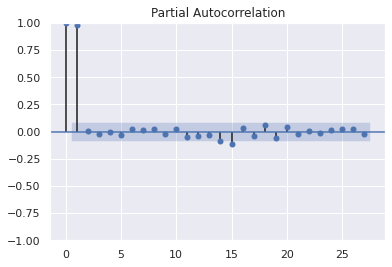

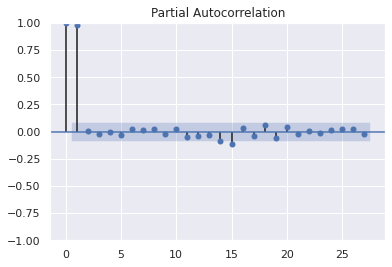

In [ ]:
sm.graphics.tsa.plot_pacf(df.dropna()['^N225'])

### З рисунку вище видно що поточне значення ряду корелює з попереднім значенням, що є досить поширеним явищем при дослідженні фінансових часових рядів

### Візуалізація всіх показників

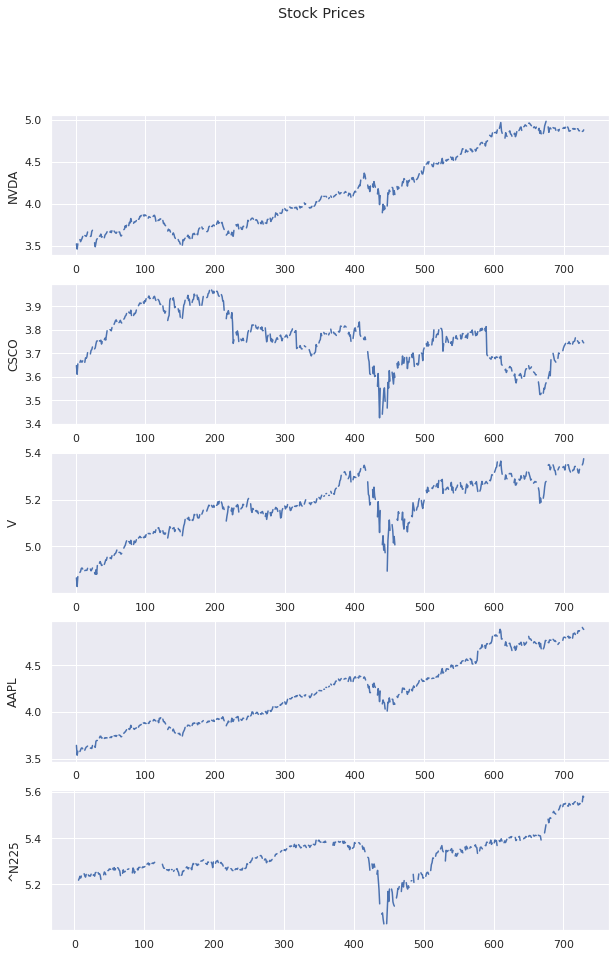

In [ ]:
plot_tickers(df)

### Матриця кореляції

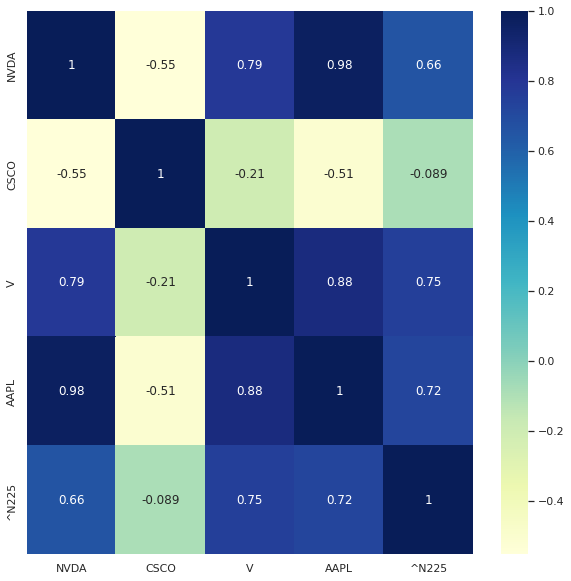

In [ ]:
plot_correlation(df)

### З матриці кореляцій видно, що акції з S&P 500 (окрім Cisco) мають сильну позитивну кореляцію з індексом NIKKEI. Також спостерігається внутрішня кореляція між регресорами, тобто між акціями S&P 500

In [ ]:
X_cols = american_companies

In [ ]:
df = df.dropna()

## Для задачі прогнозування були обрані кілька моделей - лінійна регресія, LASSO регресія та дерева прийняття рішень

### Дані для навчання та тестуванння були центровані

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df[X_cols], df[japanese_index], train_size=0.66, shuffle=False)
predictions_df = y_test.copy().reset_index(drop=True)
y_train = y_train.values.ravel()
y_test = y_test.values.ravel()

### Лінійна регресія

In [ ]:
sc = StandardScaler()
X_train_sc = sc.fit_transform(X_train)
X_test_sc = sc.transform(X_test)


lr = LinearRegression()
lr.fit(X_train_sc, y_train)
predictions_df["Linear Regression"] = lr.predict(X_test_sc)
get_scores_for_model(lr, X_train_sc, y_train, X_test_sc, y_test)

,Coef. of determination,Mean Squared Error,Mean Absolute Error,Mean Absolute Percentage Error
Sample Type,,,,
Train,0.545201,0.002037,0.035180,0.006672
Test,-0.802611,0.013727,0.095105,0.017908


### Як видно, модель недостатньо добре прогнозує досліджуваний ряд, хоча показники не геть погані, але є натяк на перенавчання

### Коефіцієнти моделі

In [ ]:
lr.coef_

array([-0.04513127,  0.02465376,  0.01287357,  0.06701867])

### ElasticNet є моделлю лінійної регресії але з вбудованими L1 та L2 регуляризациями. Це є корисним підходом при вирішенні проблеми перенавчання та при спрощенні моделі за рахунок усунення нерелевантних ознак

In [ ]:
lr = ElasticNetCV(l1_ratio=[0.01, 0.05, 0.15, 0.25, 0.3, 0.5, 0.75, 0.85, 1.], cv=3, tol=0.001, eps=0.01)
lr.fit(X_train_sc, y_train)
predictions_df["ElasticNet"] = lr.predict(X_test_sc)
get_scores_for_model(lr, X_train_sc, y_train, X_test_sc, y_test)

,Coef. of determination,Mean Squared Error,Mean Absolute Error,Mean Absolute Percentage Error
Sample Type,,,,
Train,0.351963,0.002902,0.037646,0.007121
Test,-0.657854,0.012624,0.090366,0.016980


### Показники метрик на тестовій вибірці є кращими у порівнянні з лінійною регресією без регуляризації

### Коефіцієнти моделі

In [ ]:
lr.coef_

array([0.        , 0.00855937, 0.01636099, 0.00467796])

### Дерево прийняття рішень

In [ ]:
rtree = DecisionTreeRegressor(min_samples_split=2, min_samples_leaf=35, max_depth=15)
rtree.fit(X_train_sc, y_train)
predictions_df["Decision Tree"] = rtree.predict(X_test_sc)
get_scores_for_model(rtree, X_train_sc, y_train, X_test_sc, y_test)

,Coef. of determination,Mean Squared Error,Mean Absolute Error,Mean Absolute Percentage Error
Sample Type,,,,
Train,0.783457,0.000970,0.019602,0.003722
Test,-0.409146,0.010731,0.078359,0.014665


### Як видно, дерева прийняття рішень не завжди є гарним інструментом вирішення задачі прогнозування волатильних часових рядів

### Важливість ознак

In [ ]:
rtree.feature_importances_

array([0.13850071, 0.30203244, 0.52529617, 0.03417069])

### Візуалізація прогнозів

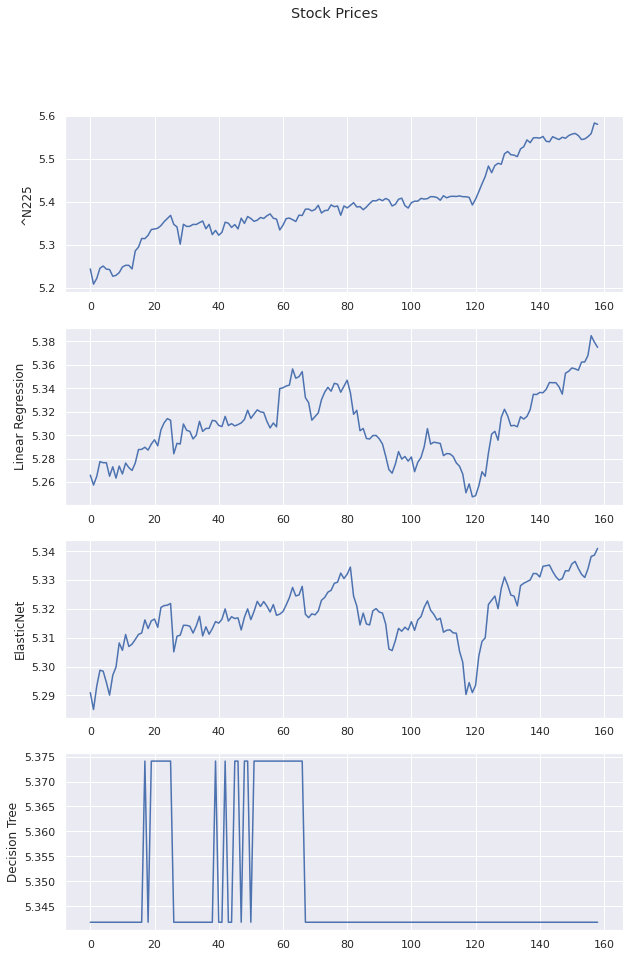

In [ ]:
plot_tickers(predictions_df)

### Побудова авторегресивної моделі. Згідно ЧАКФ можна додати лаг порядку один до регресорів


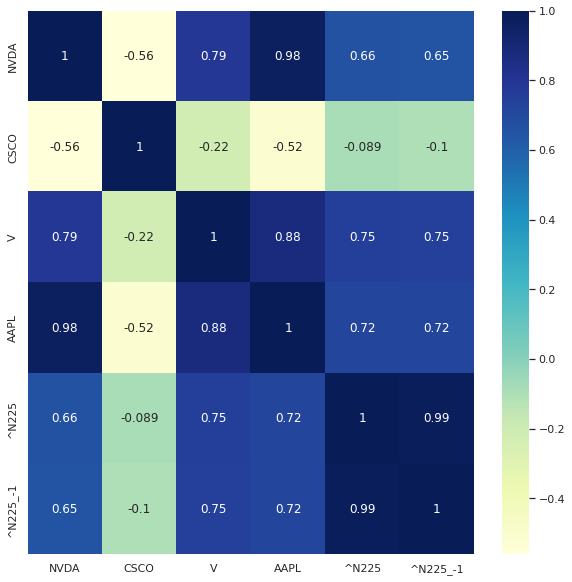

In [ ]:
lags = 1
df = shift_data(df, japanese_index[0], lags)
plot_correlation(df)

In [ ]:
df = df.dropna()

In [ ]:
X_cols = american_companies + [f'^N225_-{lag}' for lag in range(1, lags)]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df[X_cols], df[japanese_index], train_size=0.66, shuffle=False)
predictions_df = y_test.copy().reset_index(drop=True)
y_train = y_train.values.ravel()
y_test = y_test.values.ravel()

### Лінійна регресія з лагом порядку 1

In [ ]:
sc = StandardScaler()
X_train_sc = sc.fit_transform(X_train)
X_test_sc = sc.transform(X_test)


lr = LinearRegression()
lr.fit(X_train_sc, y_train)
predictions_df["Linear Regression"] = lr.predict(X_test_sc)
get_scores_for_model(lr, X_train_sc, y_train, X_test_sc, y_test)

,Coef. of determination,Mean Squared Error,Mean Absolute Error,Mean Absolute Percentage Error
Sample Type,,,,
Train,0.543952,0.002039,0.035172,0.006670
Test,-0.776401,0.013527,0.094209,0.017736


### Метрики на тестовій вибірці покращились

### Очікувано, найбільшу перевагу модель надає саме показнику індекса за попередній день

In [ ]:
lr.coef_

array([-0.04496792,  0.02499537,  0.01265692,  0.06713973])

### ElasticNet з лагом 1

In [ ]:
lr = ElasticNetCV(l1_ratio=[0.01, 0.05, 0.15, 0.25, 0.3, 0.5, 0.75, 0.85, 1.], cv=3, tol=0.001, eps=0.01)
lr.fit(X_train_sc, y_train)
predictions_df["ElasticNet"] = lr.predict(X_test_sc)
get_scores_for_model(lr, X_train_sc, y_train, X_test_sc, y_test)

,Coef. of determination,Mean Squared Error,Mean Absolute Error,Mean Absolute Percentage Error
Sample Type,,,,
Train,0.350221,0.002904,0.037664,0.007125
Test,-0.655400,0.012606,0.090278,0.016963


### Метрики на тестовій вибірці покращились

In [ ]:
lr.coef_

array([0.        , 0.00855051, 0.01639787, 0.00458699])

### В даному випадку можна побачити як введення L1 регуляризації дозволяє моделі оптимізувати свою структуру, та більше того, не опиратися лише на значення показника з найбильшобю кореляцією

### Дерева прийняття рішень

In [ ]:
rtree = DecisionTreeRegressor(min_samples_split=2, min_samples_leaf=3, max_depth=150)
rtree.fit(X_train_sc, y_train)
predictions_df["Decision Tree"] = rtree.predict(X_test_sc)
get_scores_for_model(rtree, X_train_sc, y_train, X_test_sc, y_test)

,Coef. of determination,Mean Squared Error,Mean Absolute Error,Mean Absolute Percentage Error
Sample Type,,,,
Train,0.9785,0.000096,0.004734,0.000901
Test,-0.7000,0.012945,0.095174,0.017855


### Показники погіршились. Причина тому - перенавчання моделі, що видно з показників важливості ознак

In [ ]:
rtree.feature_importances_

array([0.36722764, 0.08451877, 0.49168833, 0.05656525])

### Візуалізація прогнозів

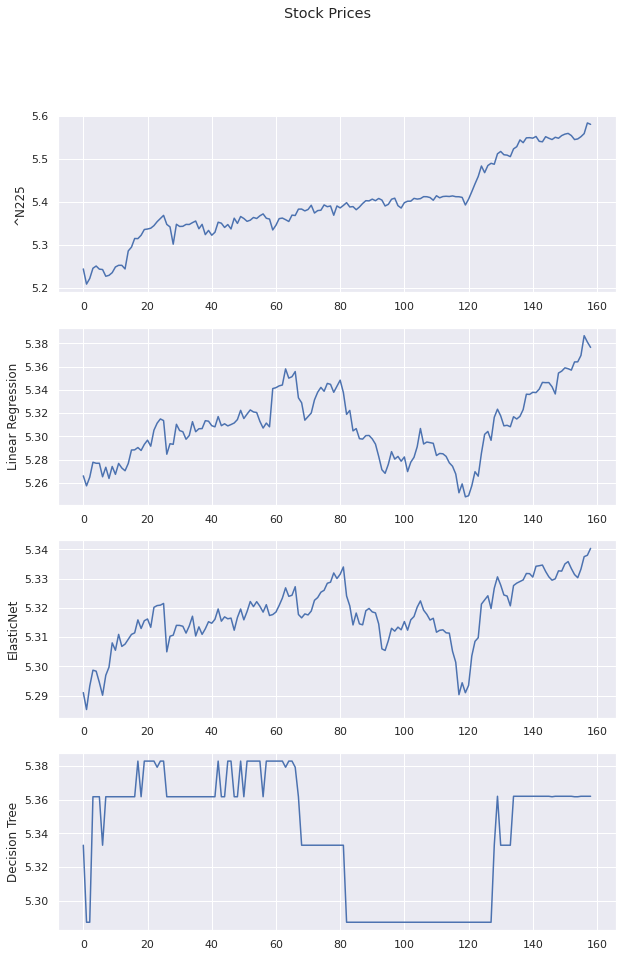

In [ ]:
plot_tickers(predictions_df)